<a href="https://colab.research.google.com/github/cesarfda/Practice/blob/master/House_Prices_Prediction_using_DF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241001%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241001T153858Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dab2c8eef1405f771c09acf205bf5edf8157ffb9949b830b8ea1c4ed132bb113b0fe8d13fd0c207778f6fdc8c99ba82e640f50516f0d5bdd6f7fd02e699f4775c1845463702ca232fce5e6384c43d11417011fd5043042247c6c86c89e5b4185c58394004a49987e9c19d7899ec2bc80e2f7e853365b1fd9e903878bde472987a74c9f86b29c8bfe88126062ffd9becdaf37cfca40a7fd11813178b0fbb956c70e340a19aebcae75ee0ce6a985e1878076d7b1116b7256eed2d8467b00ec979b072ef109a891888ef3770014cc680749c36615834448388e69a6059703565d1f7072d11417fca6597aed37429b06cc3fe9c083536605683be56b7460b3871e23d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: house-prices-advanced-regression-techniques
Data source import complete.


# House Prices Prediction using TensorFlow Decision Forests

## Import the library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance


## Load the dataset


In [4]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [5]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We will drop the `Id` column as it is not necessary for model training.

In [6]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## House Price Distribution

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


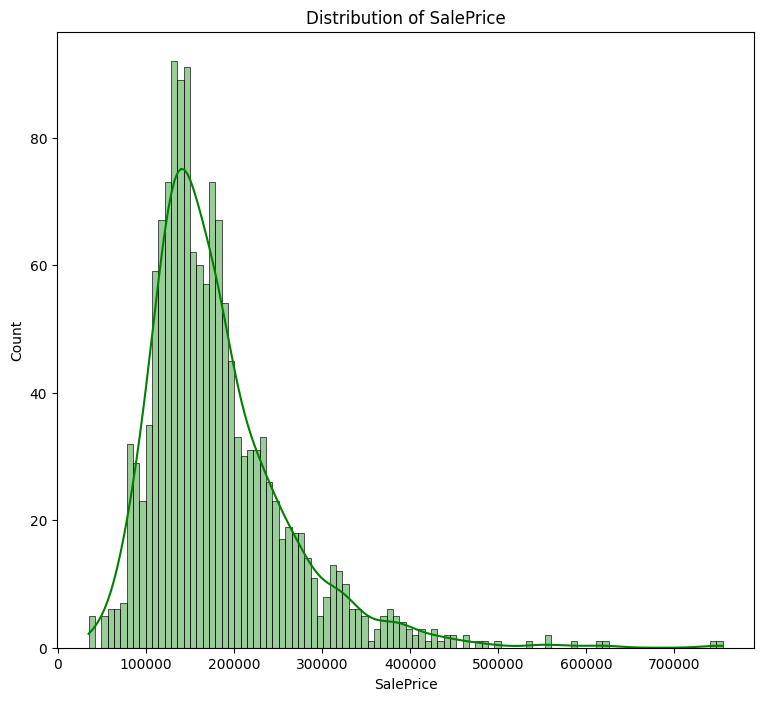

In [7]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(dataset_df['SalePrice'], color='g', bins=100, kde=True, alpha=0.4)
plt.title('Distribution of SalePrice')
plt.show()

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [8]:
numerical_features = dataset_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("Numerical Features:", numerical_features)

Numerical Features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


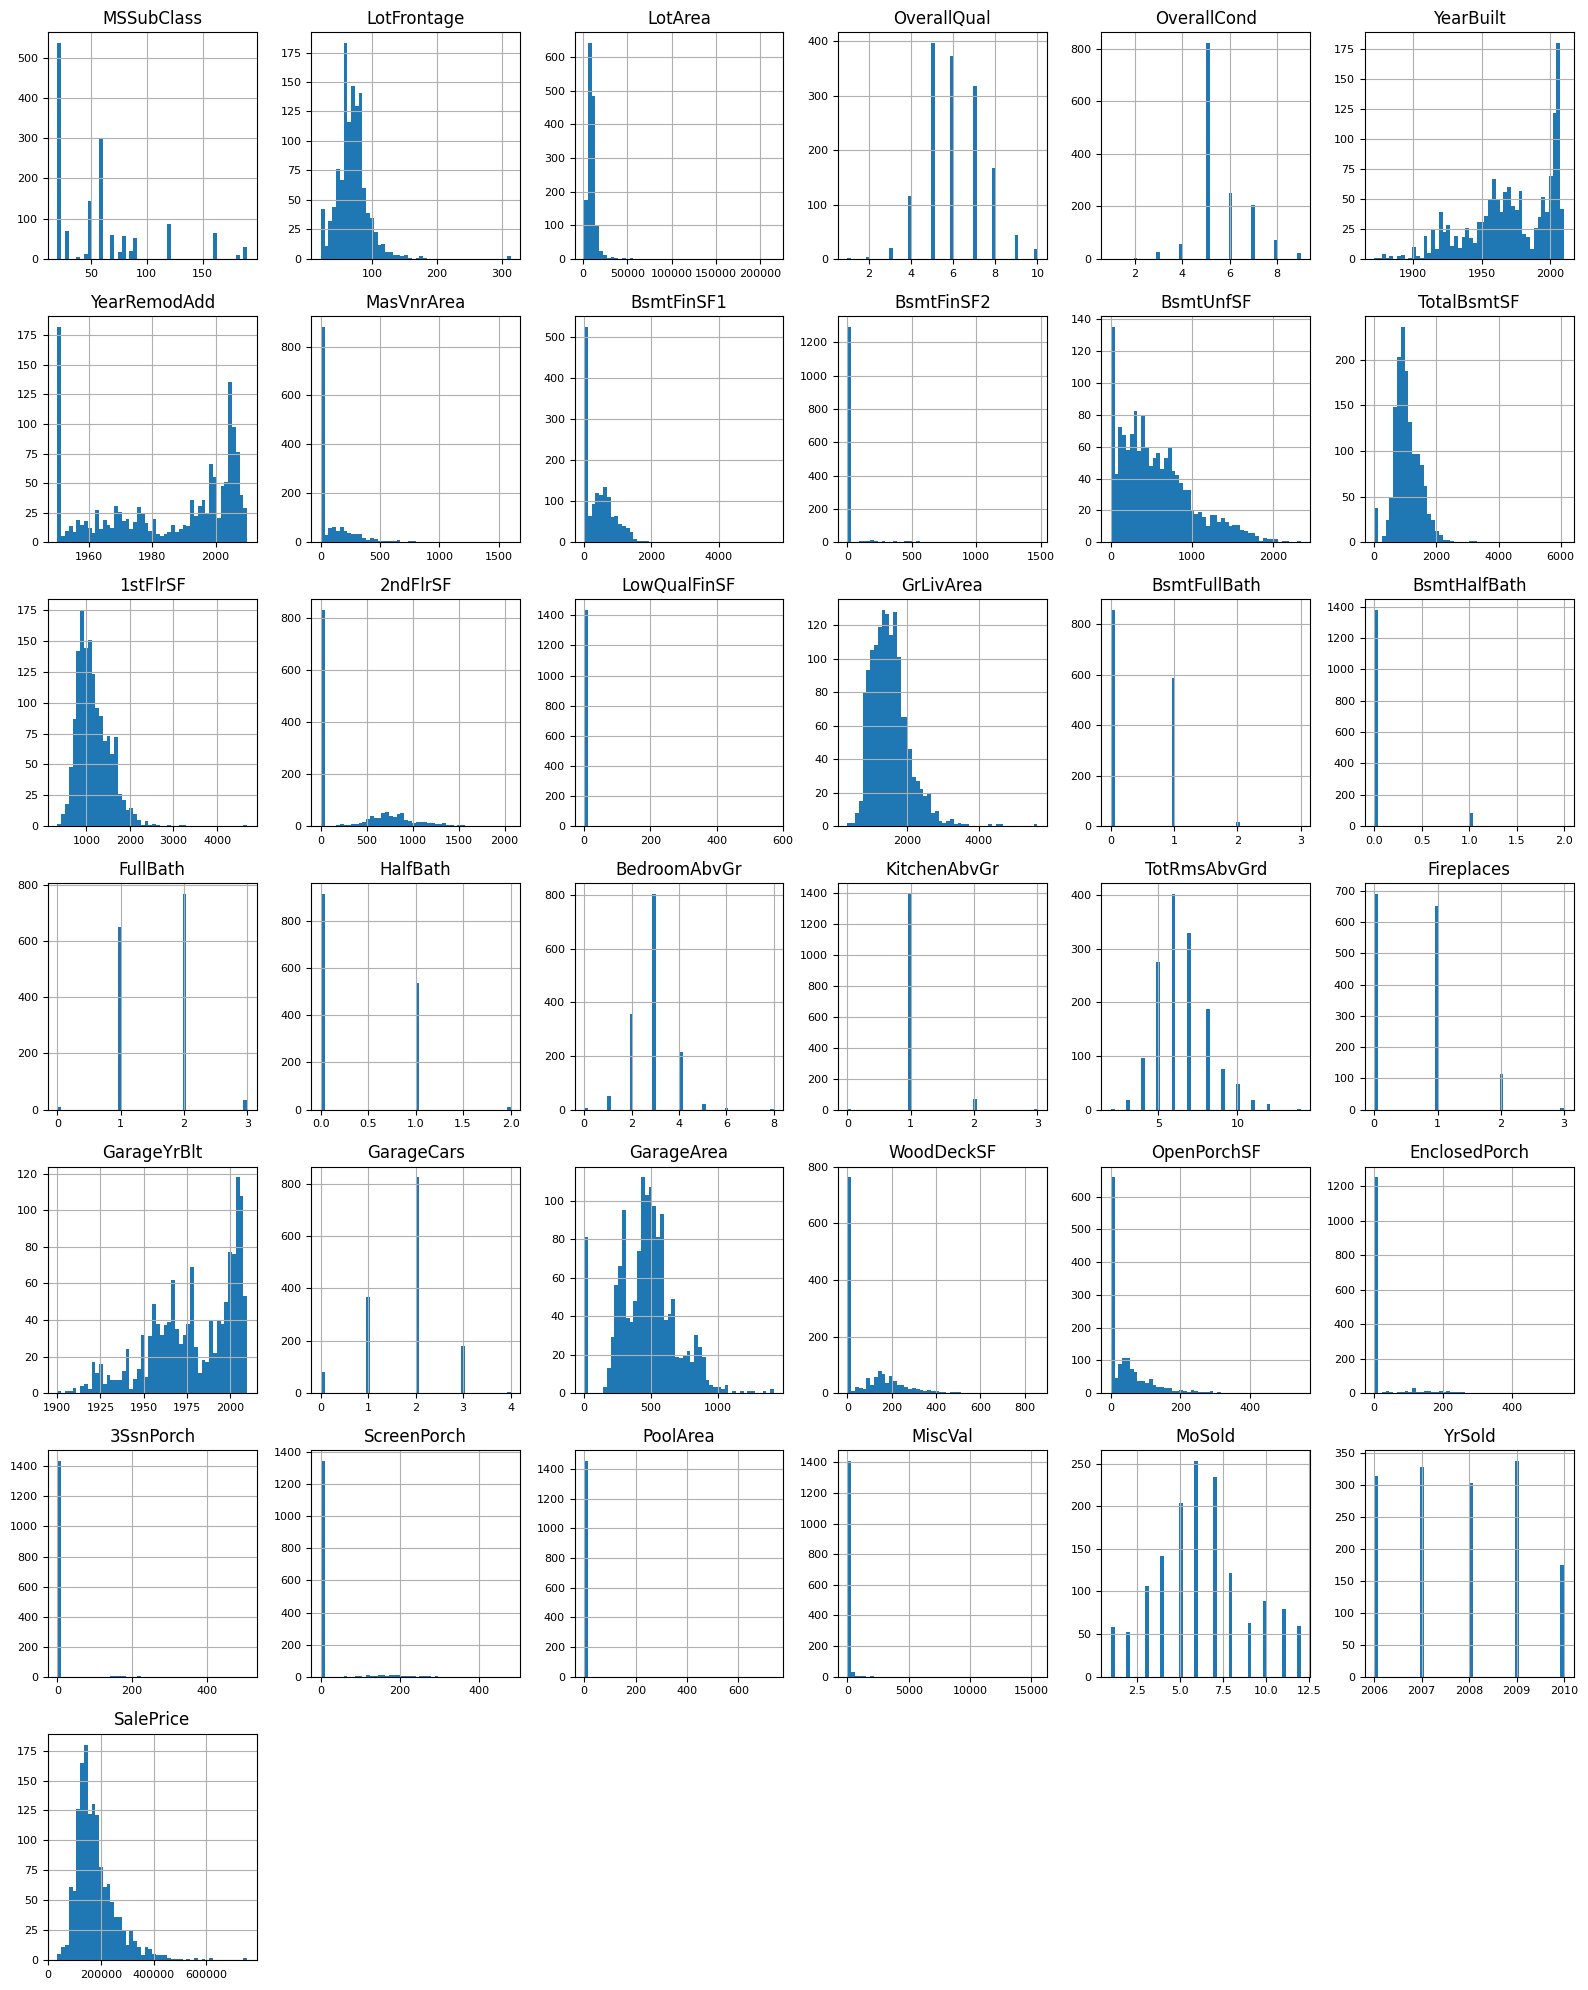

In [9]:
dataset_df[numerical_features].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

Now let us split the dataset into training and testing datasets:

In [10]:
X = dataset_df.drop('SalePrice', axis=1)
y = dataset_df['SalePrice']
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.30, random_state=42
)
print(f"{train_X.shape[0]} examples in training, {valid_X.shape[0]} examples in validation.")


1022 examples in training, 438 examples in validation.


In [11]:
# Identify categorical features
categorical_features = train_X.select_dtypes(include=['object']).columns.tolist()
print("Categorical Features:", categorical_features)

# Perform one-hot encoding
train_X_encoded = pd.get_dummies(train_X, columns=categorical_features, drop_first=True)
valid_X_encoded = pd.get_dummies(valid_X, columns=categorical_features, drop_first=True)

# Align the training and validation dataframes by columns
train_X_encoded, valid_X_encoded = train_X_encoded.align(valid_X_encoded, join='left', axis=1, fill_value=0)


Categorical Features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [12]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [13]:
rf.fit(train_X_encoded, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.4s finished


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42, verbose=1)

## Visualize the model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

## Evaluate the model on the Out of bag (OOB) data and the validation dataset


In [14]:
valid_preds = rf.predict(valid_X_encoded)
mse = mean_squared_error(valid_y, valid_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(valid_y, valid_preds)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")

Validation RMSE: 26794.0653
Validation MAE: 16785.5588


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished


# Submission
Finally predict on the competition test data using the model.

In [17]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

In [22]:
test_X_encoded = pd.get_dummies(test_data, columns=categorical_features, drop_first=True)

# Align test data with training data
test_X_encoded, _ = test_X_encoded.align(train_X_encoded, join='left', axis=1, fill_value=0)

# Get missing columns in test data
missing_cols = set(train_X_encoded.columns) - set(test_X_encoded.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_X_encoded[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
test_X_encoded = test_X_encoded[train_X_encoded.columns]

test_preds = rf.predict(test_X_encoded)
output = pd.DataFrame({'Id': ids, 'SalePrice': test_preds})
output.head()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.4s finished


,Id,SalePrice
0,1461,127962.833333
1,1462,155610.076667
2,1463,187557.230000
3,1464,185294.180000
4,1465,205178.900000


In [23]:
test_preds = rf.predict(test_X_encoded)
output = pd.DataFrame({'Id': ids, 'SalePrice': test_preds})
output.head()


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished


,Id,SalePrice
0,1461,127962.833333
1,1462,155610.076667
2,1463,187557.230000
3,1464,185294.180000
4,1465,205178.900000


In [24]:
output.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")


Submission file saved as 'submission.csv'.
